(example_Ni(110))=

# Example System: Ni(110) using the ASE interface

In this example, we demonstrate how to use the ``viperleed.calc`` Python package and its {ref}`interface<aseapi>` to the atomic simulation environment (ASE) package with a Ni(110) surface.

The ViPErLEED {term}`API` and ASE interface are most relevant to users interested in high-throughput LEED-*I*(*V*) calculations.
We use the example of the Ni(110) surface to showcase how a surface structure can be created, customized in ASE, and then passed to ViPErLEED.
In this example, we first create a surface structure for a simple Ni(110)-(1 × 1) bulk termination.
We then remove one atom to create a (1 × 2) missing-row reconstruction and pass on both structures to ViPErLEED.

We show how to set up a ViPErLEED calculation directly from these ``ase.Atoms`` objects without writing out a {ref}`POSCAR<poscar>` file.
This yields theoretical LEED-*I*(*V*) curves, which we can easily visualize and between which we can calculate an {math}`R` factor.


```{tip}

If this is your first time running ViPErLEED, make sure to first follow the {ref}`installation instructions<installation>`.
For details on how to execute ViPErLEED on your system, see the {ref}`How to run section<how_to_run>`.

For an example on how to run ViPErLEED without the ASE interface see, for instance, {ref}`this tutorial<example_ag_100>`.
```

This example contains Python code to showcase the ASE interface and ViPErLEED API.
To follow along, you can directly copy–paste the Python code into a Python environment.
We recommend using a {term}`Jupyter` notebook to directly get visual output.

In [1]:
# ASE imports
import ase.build
from ase.visualize.plot import plot_atoms

# ViPErLEED imports
from viperleed.calc.from_ase import SlabTransform
from viperleed.calc.from_ase import plot_iv_from_csv
from viperleed.calc.from_ase import rfactor_from_csv
from viperleed.calc.from_ase import run_from_ase

# Prepare matplotlib to produce vector graphics
# in jupyter notebooks instead of raster ones.
# This seems to be broken as of June 2024 in docutils. The images are rendered
# as raster anyway in HTML and not included at all in PDF. The next version of
# docutils (0.20.2) may fix this. See
# https://sourceforge.net/p/docutils/code/9517/tree//trunk/docutils/HISTORY.txt
# However, upgrading is blocked by the dependencies of sphinx-rtd-theme.
# See https://github.com/readthedocs/sphinx_rtd_theme/issues/1557
# %config InlineBackend.figure_formats = ['svg']

# And load pyplot for displaying
import matplotlib.pyplot as plt

%matplotlib inline

## Creating the Ni surfaces

The first step is to create the Ni(110) surface structure as an `ase.atoms.Atoms` object.
We can use the convenient surface-creations tools contained in the [ase.build module](https://wiki.fysik.dtu.dk/ase/ase/build/surface.html).
Since Ni is an {term}`fcc` metal, we can use the ``ase.build.fcc110`` function.
ASE will automatically recognize ``'Ni'`` as an element name and use the correct experimental lattice constant for the structure.

We first create the bulk-truncated structure with six layers.
For our visualization below, we also add 3 Å of vacuum above and below the slab.

In [2]:
element = 'Ni'
cell_1x1 = ase.build.fcc110(element, size=(1, 1, 6), vacuum=3)

Using the `matplotlib` and the `ase.visualize` modules we can take a look at the `atoms` object:

In [3]:
def show_slab_along_z_y(atoms):
    """Return a figure with two views of `atoms` ready for showing."""
    fig, axarr = plt.subplots(1, 2, figsize=(10, 5))

    plot_atoms(atoms, axarr[0], rotation=('0x,0y,0z'))
    plot_atoms(atoms, axarr[1], rotation=('-90x,-90y,0z'))

    axarr[0].set_title('View along $(\overline{1}\overline{1}0)$')
    axarr[1].set_title('View along $(1\overline{1}0)$')

    axarr[0].set_xlabel('$(1\overline{1}0)$, $\it{x}$ axis (Å)')
    axarr[0].set_ylabel('$(001)$, $\it{y}$ axis (Å)')
    axarr[1].set_xlabel('$(001)$, $\it{y}$ axis (Å)')
    axarr[1].set_ylabel('$(110)$, $\it{z}$ axis (Å)')

    return fig

<Figure size 640x480 with 0 Axes>

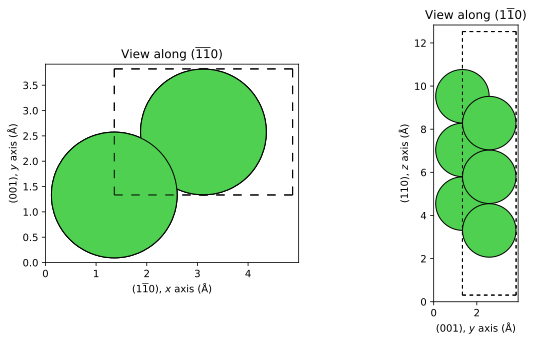

In [4]:
_ = show_slab_along_z_y(cell_1x1)

The Ni atoms are depicted as green spheres and the unit cell (periodic boundary conditions along {math}`x` and {math}`y`) is indicated with a dashed line.
The surface is facing upwards, towards larger {math}`z` coordinates, as per {ref}`ViPErLEED convention<conventions>`.

To create the missing-row reconstruction, we first make a slab with a (1 × 2) supercell and six layers.
In the `ase.Atoms` object, the atoms are currently sorted from lowest to highest, which we can double check by listing their positions.

In [5]:
supercell_1x2 = ase.build.fcc110(element, size=(1, 2, 6), vacuum=3)

# Show fractional coordinates of Ni atoms
supercell_1x2.get_scaled_positions()

array([[0.5       , 0.25      , 0.24544817],
       [0.5       , 0.75      , 0.24544817],
       [0.        , 0.        , 0.3472689 ],
       [0.        , 0.5       , 0.3472689 ],
       [0.5       , 0.25      , 0.44908963],
       [0.5       , 0.75      , 0.44908963],
       [0.        , 0.        , 0.55091037],
       [0.        , 0.5       , 0.55091037],
       [0.5       , 0.25      , 0.6527311 ],
       [0.5       , 0.75      , 0.6527311 ],
       [0.        , 0.        , 0.75455183],
       [0.        , 0.5       , 0.75455183]])

To create the missing-row reconstruction, we thus need to remove one of the two atoms in the surface layer.
We simply duplicate the supercell and create the missing-row reconstruction by removing the last atom:

<Figure size 640x480 with 0 Axes>

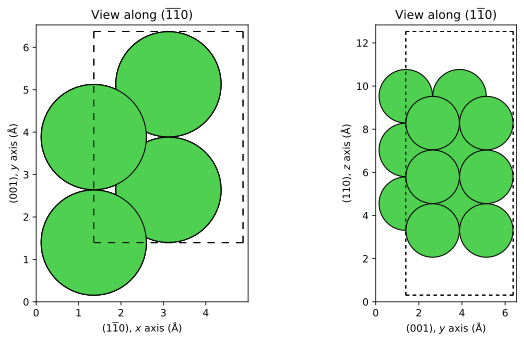

<Figure size 640x480 with 0 Axes>

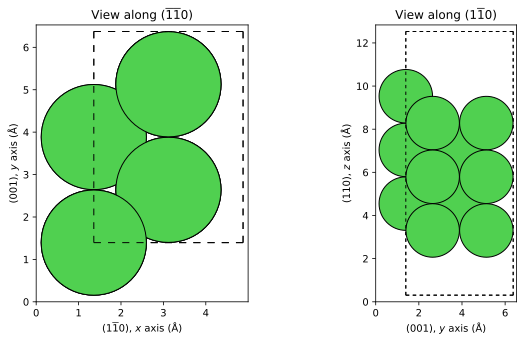

In [6]:
missing_row_1x2 = supercell_1x2.copy()
del missing_row_1x2[-1]

_ = show_slab_along_z_y(supercell_1x2)    # Bulk-truncated (1x2)
_ = show_slab_along_z_y(missing_row_1x2)  # Missing-row reconstruction

## ViPErLEED Input

Now that we have a slab, we can prepare the ViPErLEED calculation. Apart from the input structure, ViPErLEED needs some additional information to run.
Multiple {ref}`input files<list_input_files>` should be present in a {ref}`source directory<how_to_run>`. 
For this example, we create a temporary directory to run the calculation using the [Python tempfile module](https://docs.python.org/3/library/tempfile.html), but you can also use a persistent path.

In [7]:
import tempfile
from pathlib import Path

bulk_term_dir = Path(tempfile.mkdtemp())
missing_row_dir = Path(tempfile.mkdtemp())

tempdirs = [bulk_term_dir, missing_row_dir]

### Input Files
The ViPErLEED ASE interface allows you to specify a separate path (argument ``inputs_path``) from which other input files will be copied.
This can be useful, for example, for batch processing of test structures with similar settings.

In [8]:
inputs_path = '../../_static/example_systems/Ni(110)/'

In our case, we provide two files in the input directory: {ref}`PARAMETERS<parameters>` and {ref}`IVBEAMS<ivbeams>`.

#### PARAMETERS

As usual, we provide settings using the {ref}`PARAMETERS file<parameters>` (see {numref}`list_ni_parameters`).
In the ViPErLEED ASE interface you can use all parameters available in a typical ViPErLEED run.

(list_ni_parameters)=
```{literalinclude} /_static/example_systems/Ni(110)/PARAMETERS
   :language: console
   :caption: PARAMETERS file for Ni(110)-(1 × 2).
```

##### Global Parameters

As usual, we chose the reference calculation by setting {ref}`RUN = 1<run>`.
We can further specify the energy range to calculate ({ref}`THEO_ENERGIES<theo_energies>`), and the maximum angular-momentum quantum number to use  ({ref}`LMAX<lmax>`).

Normally, ViPErLEED would stop execution after the initialization the first time we run with a new structure.
This is to allow the user to check the recognized symmetry and the potentially reduced POSCAR file.
For this run via the ASE interface we want to avoid this behavior.
To do so, we can set {ref}`HALTING = 3<halting>`, which means that ViPErLEED will continue running unless it encounters an error.

##### Structure Interpretation

We don't have a {ref}`POSCAR file<poscar>`, but we can still use the {ref}`BULK_LIKE_BELOW` parameter to tell ViPErLEED how to distinguish between the surface and the bulk.
In this example, we can use the bottom two layers as bulk layers, so we can use a value of 0.42 (compare {math}`z` positions as shown above).

The ASE interface also has one more feature that we can use here: By leaving out the {ref}`SITE_DEF<sitedef>` parameter, we tell ViPErLEED to use automatic site detection. See {ref}`here<aseapi_auto_sites>` for more details on how this works.

##### VIBROCC Parameters
Since we don't provide a {ref}`VIBROCC file<vibrocc>`, we need to specify the {ref}`T_DEBYE<t_debye>` {cite:p}`george1967debyeNi`, {ref}`T_EXPERIMENT<t_experiment>`, and {ref}`VIBR_AMP_SCALE<VIBR_AMP_SCALE>` parameters. The latter is especially important because of automatic site detection: `surf`-labeled sites are created in the background for atoms at the surface.


#### IVBEAMS

Since we want to perform a theory–theory comparison and don't have an {ref}`EXPEBEAMS file<expbeams>`, we also need to provide the {ref}`IVBEAMS<ivbeams>` file, which specifies for which diffraction beams output spectra should be generated.
We will use a very simple IVBEAMS with just four beams, shown in {numref}`list_ni_ivbeams`.

(list_ni_ivbeams)=
```{literalinclude} /_static/example_systems/Ni(110)/IVBEAMS
   :language: console
   :caption: IVBEAMS file for Ni(110)-(1 × 2).
```

## Running ViPErLEED

We can now start the ViPErLEED calculation using the ``run_from_ase`` function we imported at the top.
Using ``exec_path`` we specify the directory where to execute the calculation, and with ``inputs_path`` we provide the directory that contains the input files.
The `ase.Atoms` objects is passed via ``ase_object``.
Finally, we can specify the ``slab_transforms`` argument. This parameter can be used to apply one or more transformations to the `ase.Atoms` object. These include rotations/mirroring of the coordinate frame to have the surface-normal direction along {math}`z`, and removing atoms below a threshold (as fraction of the {math}`\mathbf{c}` unit vector). This can be useful if you are starting from a symmetric slab, such as those commonly used in {term}`DFT` calculations. In our case, we want to keep the entire slab, so we simply set ``cut_cell_c_fraction=0``. (We could equally not specify any ``slab_transforms``, as the default is to not apply any processing to the slab.)

We use the Jupyter magic command ``%%capture`` to suppress the output of the cell, which would otherwise print out the entire content of the {ref}`ViPErLEED log file<log_files>`.

In [9]:
transform = SlabTransform(cut_cell_c_fraction=0.0)

In [10]:
%%capture

refcalc_results = run_from_ase(
    exec_path=bulk_term_dir,
    inputs_path=inputs_path,
    ase_object=cell_1x1,
    slab_transforms=transform,
    )

theobeams_supercell, *_, v0i_bt = refcalc_results

TypeError: '>=' not supported between instances of 'NoneType' and 'int'

``run_from_ase`` returns four values which we store in ``refcalc_results``.
The first three objects are string versions of the contents of the output files {ref}`THEOBEAMS.csv<theobeams>`, {ref}`Complex_amplitudes_real.csv and Complex_amplitudes_imag.csv<complex_amplitudes_csv>`.
The last return value is a float number giving the value for the imaginary part of the inner potential, {math}`V_{0\mathrm{i}}`, used in the calculation.
This value could be read from PARAMETERS ({ref}`V0_IMAG<v0_imag>`) and is returned here only for convenience because it is needed for calculating the *R* factor {ref}`later on<sec_ni_rfactor>`.

We then repeat the same calculation for the supercell with the missing-row reconstruction.

In [11]:
%%capture

refcalc_results = run_from_ase(
    exec_path=missing_row_dir,
    inputs_path=inputs_path,
    ase_object=missing_row_1x2,
    slab_transforms=transform,
    )

theobeams_missing_row, *_, v0i_mr = refcalc_results

TypeError: '>=' not supported between instances of 'NoneType' and 'int'

The theoretical spectra are now available for both surfaces in the form of strings:

In [12]:
first_10_lines = '\n'.join(theobeams_missing_row.splitlines()[:10])
print(first_10_lines)

NameError: name 'theobeams_missing_row' is not defined

## Plotting the *I*(*V*) curves

We can use the ``plot_iv_from_csv`` function to plot the *I*(*V*) curves for both surfaces to visually compare them:

In [ ]:
# Legends for plot
legends = (f'{element}(110)-(1 × 1) Bulk Terminated',
           f'{element}(110)-(1 × 2) Missing Row')

# Call plot_iv_from_csv from ASE interface
figs = plot_iv_from_csv(
    beam_file=(theobeams_supercell, theobeams_missing_row),
    beam_file_is_content=(True, True),
    legends=legends,
    )
plt.show(figs)

(sec_ni_rfactor)=
## *R*-factor calculation

Finally, we can also easily calculate the *R* factor between the two curves using the ViPErLEED ASE interface using the ``rfactor_from_csv`` function.
As input, we provide the two string representations of ``THEOBEAMS.csv``.
Additionally, we need to specify the value of {math}`V_{0\mathrm{i}}` returned by the calculations above, since it factors into the *R* factor (see {ref}`the page<r-factor_calculation>` on *R* factors for details).

```{hint}

If you want to compare with a stored {ref}`EXPBEAMS<expbeams>` or {ref}`THEOBEAMS<theobeams>` file, you can also provide the path to the file rather than its contents as a string.
In that case, you need to set the value of ``beams_file_is_content`` at the corresponding index to ``False``.
```

In [ ]:
# Make sure V0i is same in both cases
assert v0i_bt == v0i_mr

v0i = v0i_bt

In [ ]:
rfactor, v0r = rfactor_from_csv(
    beams_files=(theobeams_supercell, theobeams_missing_row),
    v0i=v0i,
    beams_file_is_content=(True, True),
    )

print(f'R factor: {rfactor:.4f}, with {v0r:.3f} eV shift')

Even though the *I*(*V*) curves look qualitatively similar, they quantitatively differ significantly. This is reflected in the large *R*-factor value. This is, of course, expected when comparing two different structures.

**TODO**: say something more detailed about the differences, probably about the positions of minima and maxima. Point out that the absolute intensities don't really matter much.

Finally, as a last step, let's not forget to clean up the temporary directories created before:

In [ ]:
import shutil

# Remove temporary directories
for t_dir in tempdirs:
    shutil.rmtree(t_dir)